In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime

# Load the dataset
file_path = 'D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_modified.csv'
data = pd.read_csv(file_path)

# Feature Engineering

# 1. Debt-to-Income Ratio (Assuming columns 'TotalDebt' and 'Income' exist)
if 'TotalDebt' in data.columns and 'Income' in data.columns:
    data['Debt_to_Income_Ratio'] = data['TotalDebt'] / data['Income']

# 2. Credit Utilization Ratio (Assuming 'CreditLimit' and 'CurrentCreditUsage' exist)
if 'CreditLimit' in data.columns and 'CurrentCreditUsage' in data.columns:
    data['Credit_Utilization_Ratio'] = data['CurrentCreditUsage'] / data['CreditLimit']

# 3. Income Level (Binned)
data['Income_Level'] = pd.cut(data['Income'], bins=[0, 40000, 80000, 120000, 200000], labels=['Low', 'Medium', 'High', 'Very High'])

# 4. Total Transaction Count (Assuming transaction data)
if 'TransactionCount' in data.columns:
    data['Total_Transactions'] = data['TransactionCount']

# 5. Age Group
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-Aged', 'Senior'])

# 6. Current Product Count
product_columns = ['Mortgage', 'Personal_Loan', 'Credit_Card']
data['Current_Product_Count'] = data[product_columns].sum(axis=1)

# 7. Time Since Last Product Purchase (Assuming 'LastProductPurchaseDate' exists)
if 'LastProductPurchaseDate' in data.columns:
    data['LastProductPurchaseDate'] = pd.to_datetime(data['LastProductPurchaseDate'], errors='coerce')
    data['Days_Since_Last_Purchase'] = (datetime.now() - data['LastProductPurchaseDate']).dt.days

# 8. RFM Metrics
# Assuming 'LastTransactionDate' and 'TransactionAmount' exist
if 'LastTransactionDate' in data.columns and 'TransactionAmount' in data.columns:
    data['LastTransactionDate'] = pd.to_datetime(data['LastTransactionDate'], errors='coerce')
    data['Recency'] = (datetime.now() - data['LastTransactionDate']).dt.days
    data['Frequency'] = data['TransactionCount']
    data['Monetary'] = data['TransactionAmount']

# Encode categorical variables
label_enc = LabelEncoder()
data['Income_Level'] = label_enc.fit_transform(data['Income_Level'])
data['Age_Group'] = label_enc.fit_transform(data['Age_Group'])

# Standardize numerical columns for consistency
scaler = StandardScaler()
numerical_columns = ['Debt_to_Income_Ratio', 'Credit_Utilization_Ratio', 'Total_Transactions', 
                     'Current_Product_Count', 'Days_Since_Last_Purchase', 'Recency', 'Frequency', 'Monetary']
for col in numerical_columns:
    if col in data.columns:
        data[col] = scaler.fit_transform(data[[col]])

# Save the enhanced dataset for modeling
data.to_csv('D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv', index=False)
print("Enhanced dataset saved as 'simulated_lendingclub_dataset_enhanced.csv'")


Enhanced dataset saved as 'simulated_lendingclub_dataset_enhanced.csv'


In [1]:
!pip install joblib==1.2.0


In [2]:
# !pip install joblib==1.0.1 markupsafe==2.0.1


In [3]:
# !pip install imbalanced-learn


Accuracy: 0.585
Confusion Matrix:
 [[100  48]
 [ 35  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71       148
           1       0.26      0.33      0.29        52

    accuracy                           0.58       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.62      0.58      0.60       200



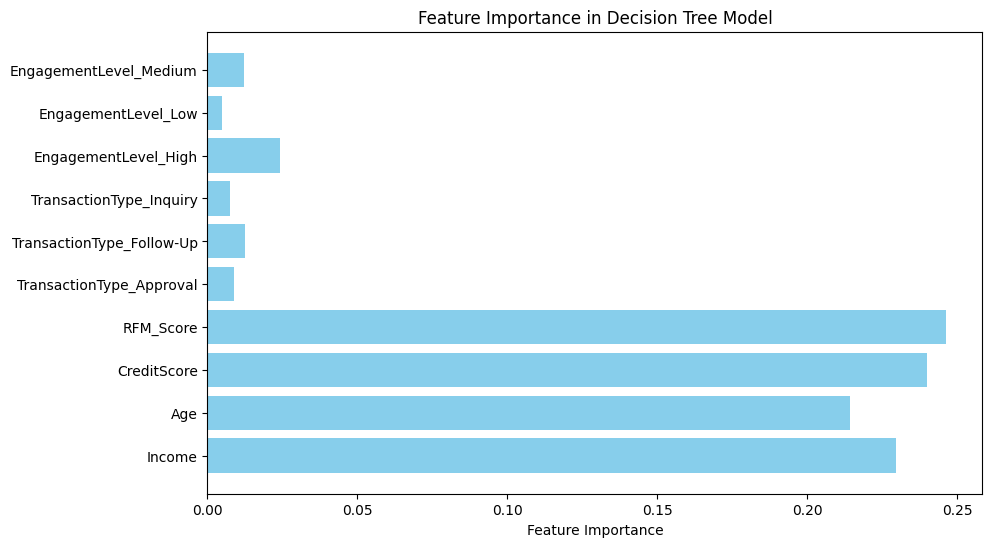

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

# Load data
file_path = 'D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Step 1: Creating a Test Set
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 2: Data Preprocessing
X_train = train_data.drop(columns=['Exited', 'CustomerID'])
y_train = train_data['Exited']
X_test = test_data.drop(columns=['Exited', 'CustomerID'])
y_test = test_data['Exited']

# Identifying numeric and categorical features
numeric_features = ['Income', 'Age', 'CreditScore', 'RFM_Score']
categorical_features = ['TransactionType', 'EngagementLevel']

# Preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Step 3: Addressing Class Imbalance
# class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Convert classes to a NumPy array to avoid InvalidParameterError
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Step 4: Building and Training the Decision Tree Model
decision_tree = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
decision_tree.fit(X_train_preprocessed, y_train)

# Step 5: Model Evaluation
y_pred = decision_tree.predict(X_test_preprocessed)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Step 6: Feature Importance
feature_names = numeric_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))
feature_importances = decision_tree.feature_importances_

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.show()


In [ ]:
# DECESSION TREE

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load data
file_path = 'D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Step 1: Creating Train, Test, and Unseen Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, unseen_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Step 2: Define Numeric and Categorical Features
numeric_features = ['Income', 'Age', 'CreditScore', 'RFM_Score']
categorical_features = ['TransactionType', 'EngagementLevel']

# Step 3: Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Step 4: Separate Target and Train for Each Product
def train_model_for_product(product_col):
    X_train = train_data.drop(columns=['CustomerID', 'Exited', 'Mortgage', 'Personal_Loan', 'Credit_Card'])
    y_train = train_data[product_col]
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    model = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
    model.fit(X_train_preprocessed, y_train)
    
    return model

# Train separate models for each product
mortgage_model = train_model_for_product('Mortgage')
personal_loan_model = train_model_for_product('Personal_Loan')
credit_card_model = train_model_for_product('Credit_Card')

# Step 5: Predict Recommendations on Unseen Data
X_unseen = unseen_data.drop(columns=['CustomerID', 'Exited', 'Mortgage', 'Personal_Loan', 'Credit_Card'], errors='ignore')
X_unseen_preprocessed = preprocessor.transform(X_unseen)

# Predict for each product separately
recommend_mortgage = mortgage_model.predict(X_unseen_preprocessed)
recommend_personal_loan = personal_loan_model.predict(X_unseen_preprocessed)
recommend_credit_card = credit_card_model.predict(X_unseen_preprocessed)

# Add recommendations to the dataframe
unseen_data['Recommend_Mortgage'] = recommend_mortgage
unseen_data['Recommend_Personal_Loan'] = recommend_personal_loan
unseen_data['Recommend_Credit_Card'] = recommend_credit_card

# Step 6: Filter for Cross-Sell/Upsell Recommendations
recommendations = unseen_data[
    ((unseen_data['Recommend_Mortgage'] == 1) & (unseen_data['Mortgage'] == 0)) |
    ((unseen_data['Recommend_Personal_Loan'] == 1) & (unseen_data['Personal_Loan'] == 0)) |
    ((unseen_data['Recommend_Credit_Card'] == 1) & (unseen_data['Credit_Card'] == 0))
]

# # Display recommendations
# print("Cross-sell/Upsell Recommendations:")
# print(recommendations[['CustomerID', 'Recommend_Mortgage', 'Recommend_Personal_Loan', 'Recommend_Credit_Card']])

# Display recommendations in a formatted output
print("Cross-sell/Upsell Recommendations:\n")
for _, row in recommendations[['CustomerID', 'Recommend_Mortgage', 'Recommend_Personal_Loan', 'Recommend_Credit_Card']].iterrows():
    print(f"CustomerID: {row['CustomerID']}, "
          f"Recommend Mortgage: {row['Recommend_Mortgage']}, "
          f"Recommend Personal Loan: {row['Recommend_Personal_Loan']}, "
          f"Recommend Credit Card: {row['Recommend_Credit_Card']}")


Cross-sell/Upsell Recommendations:

CustomerID: CUST0727, Recommend Mortgage: 0, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0267, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 0
CustomerID: CUST0766, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0799, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0747, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0475, Recommend Mortgage: 1, Recommend Personal Loan: 0, Recommend Credit Card: 1
CustomerID: CUST0043, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0769, Recommend Mortgage: 1, Recommend Personal Loan: 0, Recommend Credit Card: 1
CustomerID: CUST0381, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0155, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend

In [6]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit grid search to the preprocessed training data
grid_search.fit(X_train_preprocessed, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.5902777777777779


In [7]:
# Use best parameters to initialize a new model
best_decision_tree = DecisionTreeClassifier(**grid_search.best_params_, random_state=42, class_weight=class_weight_dict)
best_decision_tree.fit(X_train_preprocessed, y_train)


DecisionTreeClassifier(class_weight={0: 0.7058823529411765,
                                     1: 1.7142857142857142},
                       random_state=42)

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid, 
                                   scoring='accuracy', cv=5, n_iter=20, n_jobs=-1, random_state=42, verbose=2)

# Fit randomized search to the preprocessed training data
random_search.fit(X_train_preprocessed, y_train)

# Get the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}
Best Score: 0.5625


In [9]:
# Initialize the final model with the best parameters from the first Grid Search
final_decision_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight={0: 0.7058823529411765, 1: 1.7142857142857142},  # Your computed class weights
    random_state=42
)

# Train the final model on the full training set
final_decision_tree.fit(X_train_preprocessed, y_train)

# Evaluate on the test set
y_test_pred = final_decision_tree.predict(X_test_preprocessed)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", test_conf_matrix)
print("Classification Report:\n", test_class_report)


Test Accuracy: 0.615
Confusion Matrix:
 [[106  42]
 [ 35  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.73       148
           1       0.29      0.33      0.31        52

    accuracy                           0.61       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.63      0.61      0.62       200



In [10]:
# Preprocess the unseen data (excluding 'Exited' and 'CustomerID' columns)
X_unseen = unseen_data.drop(columns=['Exited', 'CustomerID'], errors='ignore')
X_unseen_preprocessed = preprocessor.transform(X_unseen)

# Use the final model to make predictions on unseen data
y_unseen_pred = final_decision_tree.predict(X_unseen_preprocessed)

# If you have the 'Exited' column in unseen data, you can evaluate the predictions
if 'Exited' in unseen_data.columns:
    y_unseen_true = unseen_data['Exited']

    # Calculate accuracy and generate classification report
    unseen_accuracy = accuracy_score(y_unseen_true, y_unseen_pred)
    unseen_conf_matrix = confusion_matrix(y_unseen_true, y_unseen_pred)
    unseen_class_report = classification_report(y_unseen_true, y_unseen_pred)

    # Display evaluation results
    print("Unseen Data Accuracy:", unseen_accuracy)
    print("Confusion Matrix on Unseen Data:\n", unseen_conf_matrix)
    print("Classification Report on Unseen Data:\n", unseen_class_report)
else:
    # Display predictions if ground truth labels are not available
    print("Predictions on Unseen Data:\n", y_unseen_pred)


Unseen Data Accuracy: 0.55
Confusion Matrix on Unseen Data:
 [[39 15]
 [21  5]]
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        54
           1       0.25      0.19      0.22        26

    accuracy                           0.55        80
   macro avg       0.45      0.46      0.45        80
weighted avg       0.52      0.55      0.53        80



In [11]:
# Collect recommendations in a DataFrame for display
recommendations_df = unseen_data[['CustomerID']].copy()  # Start with CustomerID

# Add recommendation columns based on model predictions
recommendations_df['Recommend_Mortgage'] = recommend_mortgage
recommendations_df['Recommend_Personal_Loan'] = recommend_personal_loan
recommendations_df['Recommend_Credit_Card'] = recommend_credit_card

# Filter out only the rows with recommended products (assuming customer does not own them)
recommendations_df = recommendations_df[
    ((recommendations_df['Recommend_Mortgage'] == 1) & (unseen_data['Mortgage'] == 0)) |
    ((recommendations_df['Recommend_Personal_Loan'] == 1) & (unseen_data['Personal_Loan'] == 0)) |
    ((recommendations_df['Recommend_Credit_Card'] == 1) & (unseen_data['Credit_Card'] == 0))
]

# Display recommendations in a structured format
print("Cross-sell/Upsell Recommendations:\n")
for index, row in recommendations_df.iterrows():
    print(f"CustomerID: {row['CustomerID']}, "
          f"Recommend Mortgage: {row['Recommend_Mortgage']}, "
          f"Recommend Personal Loan: {row['Recommend_Personal_Loan']}, "
          f"Recommend Credit Card: {row['Recommend_Credit_Card']}")


Cross-sell/Upsell Recommendations:

CustomerID: CUST0727, Recommend Mortgage: 0, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0267, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 0
CustomerID: CUST0766, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0799, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0747, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0475, Recommend Mortgage: 1, Recommend Personal Loan: 0, Recommend Credit Card: 1
CustomerID: CUST0043, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0769, Recommend Mortgage: 1, Recommend Personal Loan: 0, Recommend Credit Card: 1
CustomerID: CUST0381, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0155, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load data
file_path = 'D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Step 1: Creating Train, Test, and Unseen Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, unseen_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Step 2: Define Numeric and Categorical Features
numeric_features = ['Income', 'Age', 'CreditScore', 'RFM_Score']
categorical_features = ['TransactionType', 'EngagementLevel']

# Step 3: Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Step 4: Train Model for Each Product with Random Forest
def train_random_forest_for_product(product_col):
    # Prepare the target variable for each product
    X_train = train_data.drop(columns=['CustomerID', 'Exited', 'Mortgage', 'Personal_Loan', 'Credit_Card'])
    y_train = train_data[product_col]
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    # Set up Random Forest with balanced class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    rf_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
    
    # Optional: Hyperparameter tuning with Grid Search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_preprocessed, y_train)
    
    print(f"Best Parameters for {product_col}:", grid_search.best_params_)
    return grid_search.best_estimator_

# Train separate Random Forest models for each product
mortgage_rf_model = train_random_forest_for_product('Mortgage')
personal_loan_rf_model = train_random_forest_for_product('Personal_Loan')
credit_card_rf_model = train_random_forest_for_product('Credit_Card')

# Step 5: Predict Recommendations on Unseen Data
X_unseen = unseen_data.drop(columns=['CustomerID', 'Exited', 'Mortgage', 'Personal_Loan', 'Credit_Card'], errors='ignore')
X_unseen_preprocessed = preprocessor.transform(X_unseen)

# Predict for each product separately
recommend_mortgage = mortgage_rf_model.predict(X_unseen_preprocessed)
recommend_personal_loan = personal_loan_rf_model.predict(X_unseen_preprocessed)
recommend_credit_card = credit_card_rf_model.predict(X_unseen_preprocessed)

# Add recommendations to the dataframe
unseen_data['Recommend_Mortgage'] = recommend_mortgage
unseen_data['Recommend_Personal_Loan'] = recommend_personal_loan
unseen_data['Recommend_Credit_Card'] = recommend_credit_card

# Step 6: Filter for Cross-Sell/Upsell Recommendations
recommendations_df = unseen_data[['CustomerID', 'Recommend_Mortgage', 'Recommend_Personal_Loan', 'Recommend_Credit_Card']].copy()
recommendations_df = recommendations_df[
    ((recommendations_df['Recommend_Mortgage'] == 1) & (unseen_data['Mortgage'] == 0)) |
    ((recommendations_df['Recommend_Personal_Loan'] == 1) & (unseen_data['Personal_Loan'] == 0)) |
    ((recommendations_df['Recommend_Credit_Card'] == 1) & (unseen_data['Credit_Card'] == 0))
]

# Display recommendations in a structured format
print("Cross-sell/Upsell Recommendations:\n")
for index, row in recommendations_df.iterrows():
    print(f"CustomerID: {row['CustomerID']}, "
          f"Recommend Mortgage: {row['Recommend_Mortgage']}, "
          f"Recommend Personal Loan: {row['Recommend_Personal_Loan']}, "
          f"Recommend Credit Card: {row['Recommend_Credit_Card']}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Mortgage: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Personal_Loan: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Credit_Card: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-sell/Upsell Recommendations:

CustomerID: CUST0727, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0267, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 0
CustomerID: CUST0766, Recommend Mortgage: 1, Recommend Personal Loan: 0, Recommend Credit Card: 1
CustomerID: CUST0799, Recommend Mortgage: 1, Recommend Personal Loan: 1, Recommend Credit Card: 1
CustomerID: CUST0747, Recomme